<a href="https://colab.research.google.com/github/arnav39/CS779_Machine_Translation/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model-class

In [168]:
import torch
import torch.nn as nn
import random
import sys

SOS_token = 0 # index of start of sent token in the vocab

In [ ]:
class Encoder(nn.Module):

  def __init__(self, input_dim, hidden_dim, n_layers):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.gru = nn.GRU(input_dim, hidden_dim, n_layers)

  def forward(self, input, hidden):
    output, hidden = self.gru(input, hidden)
    return output, hidden

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    return hidden

In [ ]:
class Decoder(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    self.gru = nn.GRU(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size) 
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    output, hidden = self.gru(input, hidden)
    # outputs.shape : (1, batch_size, hidden_dim)
    output = self.fc(output.squeeze(0)) # (batch_size, output_dim)
    output = self.softmax(output) # (batch_size, output_dim)
    return output, hidden # (batch_size, output_dim), (num_layers, batch_size, hidden_dim)

  def init_hidden(self, batch_size):
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
    return hidden

In [ ]:
class Seq2Seq(nn.Module):

  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input, target, teacher_forcing_ratio=0.1):
    
    batch_size = input.shape[1]
    target_len = target.shape[0]

    target_vocab_size = self.decoder.output_size
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(input.device)

    # first encode the input_sequences
    encoder_hidden = self.encoder.init_hidden(batch_size)
    encoder_outputs, encoder_hidden = self.encoder(input, encoder_hidden)

    # decode the target sequences
    decoder_hidden = encoder_hidden
    decoder_input = torch.zeros(1, batch_size, self.decoder.input_size).to(input.device)

    # print(f"decoder_hidden.shape = {decoder_hidden.shape}") # (5, 6, 32)
    # print(f"decoder_input.shape = {decoder_input.shape}") # (1, 6, 10)

    # sys.exit()

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:

      for t in range(target_len):
        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

        # print(f"decoder_hidden.shape = {decoder_hidden.shape}")
        # print(f"decoder_output.shape = {decoder_output.shape}")

        # sys.exit()

        outputs[t] = decoder_output
        decoder_input = target[t].unsqueeze(0)

        # print(f"decoder_input.shape = {decoder_input.shape}")
        # sys.exit()

    else: 

      print("Not using teacher forcing")

      for t in range(target_len):
        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        outputs[t] = decoder_output # (deocder_output.shape = (batch_size, output_dim)
        top1 = decoder_output.argmax(1)
        print(f"top1.shape = {top1.shape}, batch_size = {batch_size}")
        

    return outputs

## trying out forward_pass

In [ ]:
encoder = Encoder(10, 32, 5)
encoder

Encoder(
  (gru): GRU(10, 32, num_layers=5)
)

In [ ]:
# (target_size) : (seq_len, batch_size, output_size)
t0 = torch.rand(20, 5, 400)

In [ ]:
i0 = torch.randn(20, 5, 10) # (seq_len, batch_size, input_dim)
batch_size = i0.shape[1]

encoder_hidden = encoder.init_hidden(batch_size)
print(encoder_hidden.shape) # (num_layers, batch_size, hidden_dim)

encoder_output, encoder_hidden = encoder(i0, encoder_hidden)

print(encoder_output.shape) # (seq_len, batch_size, hidden_dim)
print(encoder_hidden.shape) # (num_layers, batch_size, hidden_dim)

torch.Size([5, 5, 32])
torch.Size([20, 5, 32])
torch.Size([5, 5, 32])


In [ ]:
decoder = Decoder(10, 32, 400, 5)
decoder

Decoder(
  (gru): GRU(10, 32, num_layers=5)
  (fc): Linear(in_features=32, out_features=400, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
decoder_input = torch.zeros(1).expand(1, batch_size, 10)
print(f"decoder_input.shape = {decoder_input.shape}")

decoder_output, decoder_hidden = decoder(decoder_input, encoder_hidden)
print(f"decoder_output.shape = {decoder_output.shape}")
print(f"decoder_hidden.shape = {decoder_hidden.shape}")

decoder_input.shape = torch.Size([1, 5, 10])
decoder_output.shape = torch.Size([5, 400])
decoder_hidden.shape = torch.Size([5, 5, 32])


In [ ]:
top1 = decoder_output.argmax(1)
print(type(top1))
print(top1.shape)

<class 'torch.Tensor'>
torch.Size([5])


In [ ]:
model = Seq2Seq(encoder, decoder)
model

Seq2Seq(
  (encoder): Encoder(
    (gru): GRU(10, 32, num_layers=5)
  )
  (decoder): Decoder(
    (gru): GRU(10, 32, num_layers=5)
    (fc): Linear(in_features=32, out_features=400, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)

In [ ]:
input_seq = torch.randn(30, 6, 10) # (seq_len, batch_size, input_dim)
target_seq = torch.rand(30, 6, 10) # (seq_len, batch_size, input_dim)

In [ ]:
outputs = model(input_seq, target_seq)

Not using teacher forcing


RuntimeError: ignored

In [ ]:
print(type(outputs))
print(outputs.shape)

<class 'torch.Tensor'>
torch.Size([30, 6, 400])


## Trying new model class

In [3]:
!pip install indic-nlp-library --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.3 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import numpy as np
import torch.nn.functional as F
import spacy
from tqdm.notebook import tqdm
import sys
import gensim
from indicnlp.tokenize import indic_tokenize
import pickle
import matplotlib.pyplot as plt

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [180]:
with open('/content/drive/MyDrive/wiki.hi/inp_sent.pkl', 'rb') as f: 
  output_sent_list = pickle.load(f) # output is english

with open('/content/drive/MyDrive/wiki.hi/out_sent.pkl', 'rb') as f: 
  input_sent_list = pickle.load(f) # input is hindi

print(type(input_sent_list))
print(len(input_sent_list))

print(type(output_sent_list))
print(len(output_sent_list))

<class 'list'>
140000
<class 'list'>
140000


- let's check the lenght of the output sentences

- max_length of 64 sentences is sufficient while evaluation

In [181]:
nlp_eng = spacy.load("en_core_web_sm")
output_sent_len_list = []
for my_sent in tqdm(output_sent_list):
  doc = nlp_eng(my_sent.lower())
  tokens = [token for token in doc]
  output_sent_len_list.append(len(tokens))

  0%|          | 0/140000 [00:00<?, ?it/s]

In [184]:
print(max(output_sent_len_list), min(output_sent_len_list))

517 4


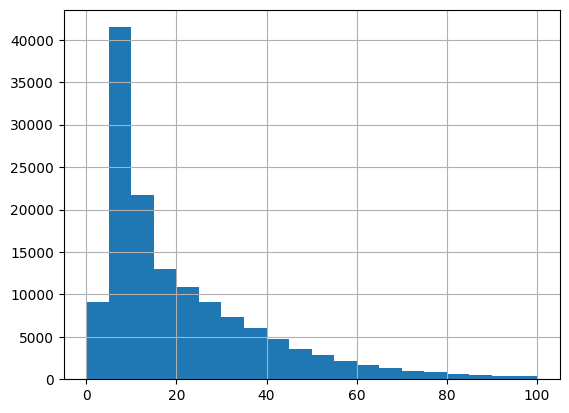

In [188]:
plt.hist(output_sent_len_list, bins=20, range=(0, 100))
plt.grid();

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/wiki.hi/wiki.hi.vec', binary=False, encoding='utf-8')
print(model.vector_size)

300


- let's try and build the vocab for output_sent_list (english)

In [ ]:
input_sent_list[0], output_sent_list[0]

('और अपनी रहमत से हमें इन काफ़िर लोगों (के नीचे) से नजात दे',
 "and deliver us by Thy mercy from the people of the unbelievers. '")

In [ ]:
nlp_english = spacy.load('en_core_web_sm')
input_eng_lang = Lang('english', nlp_english)

for my_sent in tqdm(input_sent_list):
  input_eng_lang.add_sentence(my_sent)

  0%|          | 0/140000 [00:00<?, ?it/s]

In [ ]:
print(len(input_eng_lang))

29666


- encoderGRU model class

In [ ]:
class EncoderGRU(nn.Module):

  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):

    # input.shape : (1, )

    embedded = self.embedding(input).view(1, 1, -1)
    # embedded.shape = (1, 1, hidden_size)

    output, hidden = self.gru(embedded, hidden)
    # output.shape = (1, 1, hidden_size) , (seq_len, batch_size, hidden_size)
    # hidde.shape = (1, 1, hidden_size), (num_layers, batch_size, hidden_size)

    return output, hidden 

  def init_hidden(self):
    hidden = torch.zeros(1, 1, self.hidden_size) # (num_layers, batch_size, hidden_dim)
    return hidden

- let's first understand the forward pass of the EncoderGRU

In [ ]:
encoder_try = EncoderGRU(input_size=150000, hidden_size=100)
encoder_try

EncoderGRU(
  (embedding): Embedding(150000, 100)
  (gru): GRU(100, 100)
)

In [ ]:
inp = torch.LongTensor([4])
print(inp)

tensor([4])


In [ ]:
encoder_try_hidden = encoder_try.init_hidden()
print(encoder_try_hidden.shape)

torch.Size([1, 1, 100])


In [ ]:
encoder_try_output, encoder_try_hidden = encoder_try(inp, encoder_try_hidden)

print(f"encoder_try_output.shape = {encoder_try_output.shape}")
print(f"encoder_try_hidden.shape = {encoder_try_hidden.shape}")

encoder_try_output.shape = torch.Size([1, 1, 100])
encoder_try_hidden.shape = torch.Size([1, 1, 100])


- decoderGRU model class

In [ ]:
class DecoderGRU(nn.Module):

  def __init__(self, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output[0])
    return output, hidden

  def init_hidden(self):
    hidden = torch.zeros(1, 1, self.hidden_size) # (num_layers, batch_size, hidden_size)
    return hidden

- decoderGRU forward pass

In [ ]:
decoder_try = DecoderGRU(hidden_size=100, output_size=400000)
print(decoder_try)

DecoderGRU(
  (embedding): Embedding(400000, 100)
  (gru): GRU(100, 100)
  (out): Linear(in_features=100, out_features=400000, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
inp = torch.LongTensor([0])
decoder_try_hidden = encoder_try_hidden

decoder_try_output, decoder_try_hidden = decoder_try(inp, decoder_try_hidden)

print(f"decoder_try_output.shape = {decoder_try_output.shape}")
print(f"decoder_try_hidden.shape = {decoder_try_hidden.shape}")

decoder_try_output.shape = torch.Size([1, 400000])
decoder_try_hidden.shape = torch.Size([1, 1, 100])


In [ ]:
decoder_try_target = torch.LongTensor([3])
loss_try = nn.CrossEntropyLoss()

my_loss = loss_try(decoder_try_output, decoder_try_target)
print(my_loss)

tensor(12.9479, grad_fn=<NllLossBackward0>)


- train function

In [ ]:
def train(input_tensor: torch.Tensor, target_tensor: torch.Tensor, encoder: EncoderGRU, decoder: DecoderGRU, encoder_optimizer, decoder_optimizer, criterion, max_length=10):

  encoder_hidden = encoder.init_hidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0] 

  decoder_input = torch.LongTensor([0])
  decoder_hidden = encoder_hidden

  for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    # print(decoder_output)
    # print(target_tensor[di])
    # sys.exit()
    single_loss = criterion(decoder_output, target_tensor[di].view(1))
    # print(single_loss)
    # sys.exit()
    loss += single_loss
    decoder_input = target_tensor[di]

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  ans = loss.item()/target_length
  return ans

- Lang class

In [169]:
class Lang():

  def __init__(self, name, spacy_tokenizer):
    self.name = name
    self.word2index = {"<SOS>":0, '<EOS>': 1}
    self.index2word = {0: "<SOS>", 1: "<EOS>"}
    self.word2count = {}
    self.n_words = 2
    self.tokenizer = spacy_tokenizer

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1

    else:
      self.word2count[word] += 1

  def add_sentence(self, sentence):
    tokens = self.tokenize_sentence(sentence)
    for token in tokens: 
      self.add_word(token)

  def tokenize_sentence(self, sentence):
    tokens = [token.text for token in self.tokenizer(sentence.lower())]
    return tokens

  def __len__(self):
    return self.n_words

- let's try training 

In [170]:
hidden_size = 256
learning_rate = 0.01
max_epochs = 100

In [ ]:
!python -m spacy download fr_core_news_sm --quiet

In [ ]:
!python -m spacy download en_core_web_sm --quiet

2023-04-11 19:18:22.795114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [177]:
nlp_french = spacy.load('fr_core_news_sm')
nlp_english = spacy.load('en_core_web_sm')

In [ ]:
input_lang = Lang('english', nlp_english)
output_lang = Lang('french', nlp_french)

training_pairs = [
    ('hello world', 'hola mundo'),
    ('goodbye', 'adios'),        
    ('how are you', 'como estas'),        
    ('i am fine', 'estoy bien')    
  ]

In [ ]:
# building the vocab
for my_pair in training_pairs: 
  input_lang.add_sentence(my_pair[0])
  output_lang.add_sentence(my_pair[1])
                           
print(f"len of input_lang = {len(input_lang)}")
print(f"len of output lang = {len(output_lang)}")

len of input_lang = 9
len of output lang = 7


In [ ]:
encoder = EncoderGRU(len(input_lang), hidden_size)
decoder = DecoderGRU(hidden_size, len(output_lang))

criterion = nn.CrossEntropyLoss()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

In [ ]:
print(encoder)

EncoderGRU(
  (embedding): Embedding(9, 256)
  (gru): GRU(256, 256)
)


In [ ]:
print(decoder)

DecoderGRU(
  (embedding): Embedding(7, 256)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=7, bias=True)
)


In [ ]:
for epoch in tqdm(range(max_epochs)):

  epoch_loss = 0

  for pair in training_pairs:

    input_tokens = input_lang.tokenize_sentence(pair[0])
    target_tokens = output_lang.tokenize_sentence(pair[1])

    input_tensor = torch.tensor([input_lang.word2index[my_token] for my_token in input_tokens])
    target_tensor = torch.tensor([output_lang.word2index[my_token] for my_token in target_tokens])

    # print(input_tensor)
    # print(target_tensor)

    # sys.exit()

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max(len(pair[0]), len(pair[1])))

    epoch_loss += loss
  
  print(f"epoch : {epoch}/{max_epochs}, LOSS = {epoch_loss/len(training_pairs)}")


  0%|          | 0/100 [00:00<?, ?it/s]

epoch : 0/100, LOSS = 3.355436861515045
epoch : 1/100, LOSS = 0.7689316719770432
epoch : 2/100, LOSS = 0.7495601363480091
epoch : 3/100, LOSS = 0.1858946888241917
epoch : 4/100, LOSS = 0.34204340749420226
epoch : 5/100, LOSS = 0.1838268730789423
epoch : 6/100, LOSS = 0.10363091417821124
epoch : 7/100, LOSS = 0.08801387756830081
epoch : 8/100, LOSS = 0.05706649151397869
epoch : 9/100, LOSS = 0.025902423076331615
epoch : 10/100, LOSS = 0.018108157033566386
epoch : 11/100, LOSS = 0.011735108215361834
epoch : 12/100, LOSS = 0.007427115750033408
epoch : 13/100, LOSS = 0.005552122747758403
epoch : 14/100, LOSS = 0.004475749432458542
epoch : 15/100, LOSS = 0.003677599976072088
epoch : 16/100, LOSS = 0.0031032061233418062
epoch : 17/100, LOSS = 0.002704462400288321
epoch : 18/100, LOSS = 0.002412775284028612
epoch : 19/100, LOSS = 0.002185628327424638
epoch : 20/100, LOSS = 0.0019862317640217952
epoch : 21/100, LOSS = 0.0018249521817779168
epoch : 22/100, LOSS = 0.001715740087092854
epoch : 23

# Bakchodi

In [5]:
a = torch.zeros(3, 4)

for i in range(6):
  a[i] = torch.randn(4)

IndexError: ignored

In [ ]:
output_size = 5

inputs = torch.randn(1, output_size)
targets = torch.randint(1, size=(1, ))

print(inputs) 
print(f"inputs.shape = {inputs.shape}")

print(targets)

b = nn.CrossEntropyLoss()
b(inputs, targets)

tensor([[-2.1149,  0.6439, -1.2692,  0.2424, -0.2459]])
inputs.shape = torch.Size([1, 5])
tensor([0])


tensor(3.5878)

In [ ]:
t = torch.tensor(0)
t

tensor(0)

In [ ]:
a1 = torch.randn(1, 7)
a2 = torch.LongTensor([2])

a = nn.CrossEntropyLoss()
a(a1, a2).item()

1.892608642578125

In [ ]:
a = 'Hello, my name is arnav, i like her.'
doc = nlp_english(a.lower())
a_tokens = [token.text for token in doc]
a_tokens

['hello', ',', 'my', 'name', 'is', 'arnav', ',', 'i', 'like', 'her', '.']

In [ ]:
x = {'apple', 'banana', 'cherry'}
y = {'google', 'microsoft', 'apple'}

print(x)
x.update(y)
print(x)

{'apple', 'banana', 'cherry'}
{'banana', 'google', 'apple', 'cherry', 'microsoft'}


In [ ]:
sorted(list(x)), list(x)

(['apple', 'banana', 'cherry', 'google', 'microsoft'],
 ['banana', 'google', 'apple', 'cherry', 'microsoft'])

In [ ]:
a = torch.tensor([[0]])
print(a.shape, a.dtype)

torch.Size([1, 1]) torch.int64


In [ ]:
a = torch.randn(10, 400000)
top = a.argmax(1)
print(f"top.shape = {top.shape}")

top.shape = torch.Size([10])


In [ ]:
top.dtype

torch.int64

In [ ]:
a = torch.LongTensor([[1]])
print(a.shape)

b = nn.Embedding(400000, 50)

a_2 = b(a)
print(f"a_2.shape = {a_2.shape}")

a_3 = a_2.view(1, 1, -1)
print(f"a_3.shape = {a_3.shape}")

torch.Size([1, 1])
a_2.shape = torch.Size([1, 1, 50])
a_3.shape = torch.Size([1, 1, 50])


In [ ]:
top = torch.randint(0, 10, (10, ))
print(top)

emb = nn.Embedding(10, 30)

x = top.unsqueeze(0) 
print(f"x.shape = {x.shape}") # (1, batch_size)

emb_x = emb(x)
print(f"emb_x.shape = {emb_x.shape}") # (1, batch_size, embedding_size)

tensor([9, 8, 9, 7, 9, 7, 3, 5, 0, 8])
x.shape = torch.Size([1, 10])
emb_x.shape = torch.Size([1, 10, 30])


In [ ]:
a = torch.rand(6)
print(a)
b = a.unsqueeze(0).unsqueeze(-1).expand(1, 6, 10)

tensor([0.7886, 0.6245, 0.8876, 0.2123, 0.4773, 0.5210])


In [ ]:
print(b)

tensor([[[0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886, 0.7886,
          0.7886, 0.7886],
         [0.6245, 0.6245, 0.6245, 0.6245, 0.6245, 0.6245, 0.6245, 0.6245,
          0.6245, 0.6245],
         [0.8876, 0.8876, 0.8876, 0.8876, 0.8876, 0.8876, 0.8876, 0.8876,
          0.8876, 0.8876],
         [0.2123, 0.2123, 0.2123, 0.2123, 0.2123, 0.2123, 0.2123, 0.2123,
          0.2123, 0.2123],
         [0.4773, 0.4773, 0.4773, 0.4773, 0.4773, 0.4773, 0.4773, 0.4773,
          0.4773, 0.4773],
         [0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210, 0.5210,
          0.5210, 0.5210]]])


In [ ]:
random.random()

0.6335462054967805

In [ ]:
a = torch.tensor([[SOS_token]*3])
a, a.shape

(tensor([[0, 0, 0]]), torch.Size([1, 3]))

In [ ]:
a = nn.GRU(10, 20, num_layers=8)
a

GRU(10, 20, num_layers=8)

In [ ]:
b = torch.randn(30, 3, 10) # (seq_len, batch_size, input_dim)
c, d = a(b)
print(type(c))
print(type(d))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(c.shape) # (seq_len, batch_size, hidden_dim)
print(d.shape) # last 

torch.Size([30, 3, 20])
torch.Size([8, 3, 20])


In [ ]:
input_seq = torch.randn(3, 10, 50) # (batch_size, seq_len, input_dim)
gru_model = nn.GRU(50, 32, 2, batch_first=True)

output, final_hidden = gru_model(input_seq)
print(f"output.shape = {output.shape}") # (batch_size, seq_len, hidden_dim) # output of the final layer
print(f"final_hidden.shape = {final_hidden.shape}") # (num_layers, batch_size, hidden_dim), this if the final hidden state of each layer

output.shape = torch.Size([3, 10, 32])
final_hidden.shape = torch.Size([2, 3, 32])


In [ ]:
a = nn.GRU(2, 3, 7)
a

GRU(2, 3, num_layers=7)

In [ ]:
batch_size = 5

inp = torch.randn(1, batch_size, 2) # (seq_len, batch_size, input_dim)
hidden = torch.zeros(7, batch_size, 3)
print(hidden.shape)

output, hidden = a(inp, hidden)
print(output.shape)
print(hidden.shape)

torch.Size([7, 5, 3])
torch.Size([1, 5, 3])
torch.Size([7, 5, 3])


In [ ]:
a = torch.zeros(1)
b = a.unsqueeze(0).unsqueeze(0).expand(1, 5, 50)
c = a.expand(1, 5, 50)
print(b.shape)
print(c)

torch.Size([1, 5, 50])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
a = torch.zeros(10, 4, 32) # (max_len, batch_size, hidden_dim)

out_1 = torch.randn(1, 4, 32)
a[0] = out_1

In [ ]:
a[0] == out_1.squeeze(0)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])